# Import libraries

In [1]:
import splineop_cpp as spop
from scipy.interpolate import PPoly
from scipy.interpolate import make_lsq_spline
import matplotlib.pyplot as plt
import numpy as np

# Generate data

In [2]:
# To easily create a quadratic spline we generate some random noise
# and fit a quadratic spline with knots chosen arbitrarily
# This fit makes no real sense, it is just an easy way to get all the continuity
# constraints right.
np.random.seed(11) 
data = np.random.normal(0,1,1000)
x = np.linspace(0,1,1000)
bpoly = make_lsq_spline(x=x,
                   y=data,
                   k=2,
                   t=np.array([0,0,0,0.25,0.38,0.79,1,1,1])
                   )
ppoly = PPoly.from_spline(bpoly)

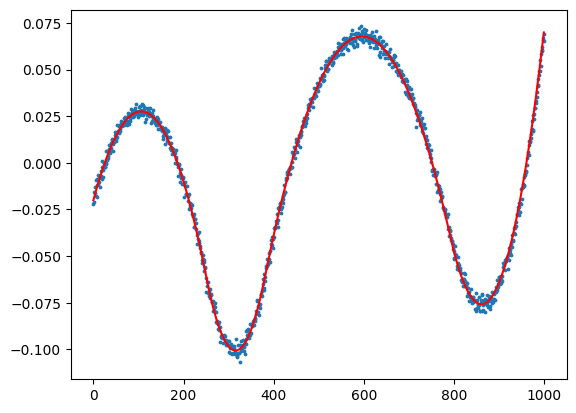

In [4]:
signal = ppoly(x)
noise_sd = 0.0025
noise = np.random.normal(0,noise_sd,1000)
noised_signal = signal + noise 

plt.scatter(x*1000,noised_signal,s=3)
plt.plot(signal, color="red")
plt.show()


In [5]:
# Current Cpp implementation takes signals of shape (ndims, nobs)
# this can be thought with a mental image (see plot above, as an example)
# that the time "advances" in the horizontal axis
reshaped_noised_signal = noised_signal.reshape(1,1000) 

# SplineOP Demonstration on synthetic data

## Penalized model

In [6]:
# init_speed_estimators is an array such that:
#   a. len(init_speed_estimators) is the number of initial speed estimators, and
#   b. init_speed_estimators[i] indicates, starting from the first point, up to where
#      to take into account for estimating the initial speed.  
init_speed_estimators = np.array([20,40,60,80,100], dtype=int)

data_var = float(0.0025**2) # Data variance here is known.
seed = 1 # seed for the random generation of states
nstates = 5 # number of states

# Instantiation of the penalized model
model_penalized = spop.SplineOP(
    reshaped_noised_signal 
    ,int(nstates)
    ,init_speed_estimators
    ,float(data_var)
    ,int(seed)    
)

In [15]:
model_penalized.predict(0.01) # Predict with a given penalty
model_penalized.changepoints # knots are at [250,380,790], [999] is just bringing the last index 

[255, 375, 790, 999]

## Constrained model

In [8]:
# init_speed_estimators is an array such that:
#   a. len(init_speed_estimators) is the number of initial speed estimators, and
#   b. init_speed_estimators[i] indicates, starting from the first point, up to where
#      to take into account for estimating the initial speed.  
init_speed_estimators = np.array([20,40,60,80,100], dtype=int)

data_var = float(0.0025**2) # Data variance here is known.
seed = 1 # seed for the random generation of states
nstates = 5 # number of states
K = 4

# Instantiation of the penalized model
model_constrained = spop.SplineOP_constrained(
     reshaped_noised_signal
    ,int(nstates)
    ,init_speed_estimators
    ,float(data_var)
    ,int(K)
    ,int(seed)    
)


In [ ]:
model_constrained.predict(3)
model_constrained.changepoints # knots are at [250,380,790], [999] is just bringing the last index 

[255, 375, 790, 999]

## Dive into the inner-workings

### States

We call _states_ for a time position $t$ to a set of values $P_t = \{p_{t,1}, \ldots ,p_{t,nstates}\}$. 

The current implementation of the CPP code does not include an API for different state creation strategies. The adopted strategies does the following : 
1. Given an input variance $\sigma^2$ and desired number of states $nstates$.
2. At each time position $t$ construct the set $P_t$ as the observations, $y_t$, plus $(nstates - 1)$ points drawn randomly from a Gaussian distribution centered in $y_t$ and with variance $\sigma^2$.  

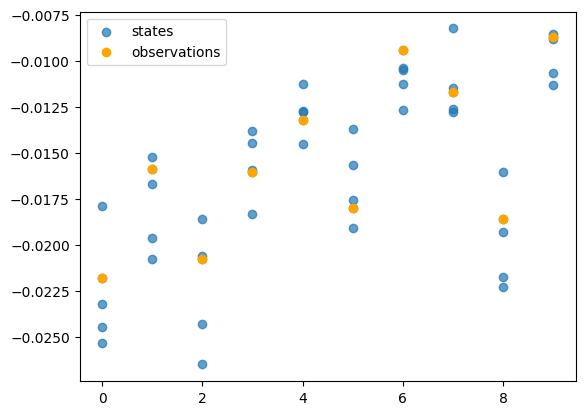

In [ ]:
# We plot the first 10 observations + the states
f, ax = plt.subplots()
x_coords = [] # placeholder for x-values of the states
y_coords = [] # placeholder for the y-values of the states
for i in range(10):
    current_states = model_penalized.states[:10][i][0]

    x_coords.extend([i] * len(current_states))
    y_coords.extend(current_states)
ax.scatter(x_coords, y_coords, alpha=0.7, label="states")
ax.scatter(x=np.arange(10),y=noised_signal[:10], color='orange',label="observations")

plt.legend()
plt.show()


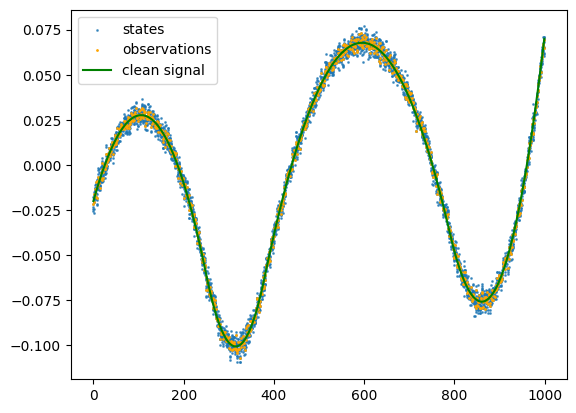

In [ ]:
# We plot the first 10 observations + the states
f, ax = plt.subplots()
x_coords = [] # placeholder for x-values of the states
y_coords = [] # placeholder for the y-values of the states
for i in range(1000):
    current_states = model_penalized.states[i][0]
    x_coords.extend([i] * len(current_states))
    y_coords.extend(current_states)
ax.scatter(x_coords, y_coords, alpha=0.7, label="states",s=1)
ax.scatter(x=np.arange(1000),y=noised_signal, color='orange',label="observations",s=1)
ax.plot(signal,color="green",label="clean signal")
plt.legend()
plt.show()


### Speeds

The algorithm also makes use of approximation of the initial speeds. These speeds are computed by a least squares fit of a quadratic polynomial on the first "few" observations, and taking as estimation the linear term.

There is no magic number for the "few", but one would normally want to be conservative so that points are taken only in the first segment. 

We can access the estimations with the `init_speeds` attribute:

In [18]:
model_penalized.init_speeds

array([[0.00073903, 0.00079837, 0.00083984, 0.00090499, 0.00089719]])

In this setting, we have perfect information and we know that the initial speed is in fact: 

In [66]:
ppoly.c[1][0]

np.float64(0.8989827073320142)

The estimated speeds get better with the number of points, since we are still within the first segment. 

If we pushed too much, getting out of the first segment, we should get a worse estimation. To verify this intuition, lets check it out below: 

In [70]:
init_speeds_example = np.array([300,500], dtype=int)

data_var = float(0.0025**2) 
seed = 1 
nstates = 5 

model_example_speeds = spop.SplineOP(
    reshaped_noised_signal 
    ,int(nstates)
    ,init_speeds_example
    ,float(data_var)
    ,int(seed)    
)
print(model_example_speeds.init_speeds )

[[ 0.0007845  -0.00080201]]


We effectively see that when we take a length larger than the first segment, we are fitting one quadratic where in fact there are two, then the estimated parameters will not be really meaningful. (recall that the real initial speed is ~0.8989) 

Finally, lets **see a plot of what these _speeds_ mean to `SplineOP`**.

When the algorithm evaluates for solutions of a single segment (previous changepoint `s=0`) the optimization is made over all states in $P_0$ and all initial speeds $\mathcal{V}_0 = $ `init_speeds`. 

First, we do some array manipulation to get all we need:

In [ ]:
speed_coords = []
# Repeat the 5 initial speeds for each of 5 the states
for i in range(5):
    speed_coords.extend(model_penalized.init_speeds) 
    
# Manipulate the shape to plot the slope in the graph
speeds = np.array([_ for _ in speed_coords])
speeds = speeds.flatten()
starting_y = np.repeat(model_penalized.states[0][0],5)
ending_y = np.repeat(model_penalized.states[0][0],5) + speeds


Now, we are ready to plot. 

We see that, for each state at time position 0, we have 5 admissible initial speeds that are equal for each state.

Again, this are the initial speeds over which the optimization happens in the Dynamic Programming loop when `s=0`. 

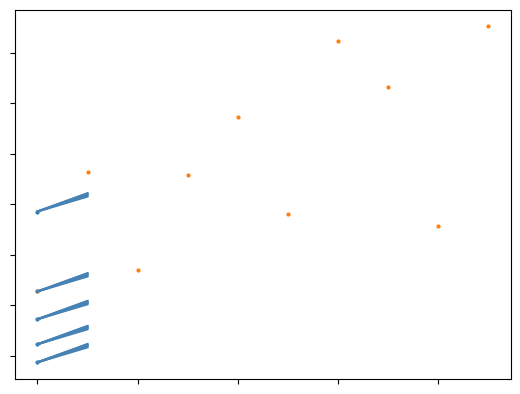

In [ ]:
f, ax = plt.subplots()
# Pair together the starting and ending points
for y0, y1 in zip(starting_y, ending_y):
    # Plot from x=[0, 1] to y=[y0, y1]
    ax.plot([0, 1], [y0, y1], color='steelblue', alpha=1)
ax.scatter([0]*5,model_penalized.states[0][0],s=4)
ax.scatter(np.arange(10),noised_signal[:10],s=4)
# Remove ticklabels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()